# Imports

In [14]:
import numpy as np
import pandas as pd
import json
import os
from matplotlib import pyplot as plt
from glob import glob

%matplotlib inline

# Data Reading

Specifying the directory containing the participant data.

In [4]:
DATA_DIR = '../data/sessions/participants/'

Specifying the fileformat glob of the config files.

In [5]:
datafiles = glob(DATA_DIR+'*.json')

Looping through each config file and reading the data into a variable.

In [12]:
configs = []
for file in datafiles:
    with open(file) as infile:
        configs.append(json.load(infile))

In [29]:
list(configs[0].keys())

['TESTING',
 'NTRIALS',
 'NCUES',
 'GRID_TYPE',
 'NO_NUMPAD',
 'XSIZE',
 'YSIZE',
 'SCALE',
 'EXSIZE',
 'EYSIZE',
 'IMAGE_TEMPLATE',
 'IMAGE_SIZE',
 'IMAGE_SCALE',
 'DATETIME_FORMAT',
 'DIGIT_SOUND_TEMPLATE',
 'CONFIG_FILE_TEMPLATE',
 'SESSION_FILE_TEMPLATE',
 'CORRECT_NOTE',
 'INCORRECT_NOTE',
 'NOTE_DURATION',
 'NOTE_VOLUME',
 'SESSION_VARS',
 'SESSION_HEADER',
 'SESSION_ROW_TEMPLATE',
 'PROMPT_TEXT',
 'END_TEXT',
 'KEY_LIST',
 'EXCLUDED',
 'details',
 'configFile',
 'sessionFile']

Each config in `configs` contains the name of the session file, relative to root directory of `03-psychophysics`. First, we change the current directory.

In [15]:
os.chdir('../')

Then read all the file data.

In [17]:
data = [pd.read_csv(config['sessionFile']) for config in configs]

And examining the first ten rows of the first data file:

In [19]:
data[0][:10]

,trial,cue,digit,keypress,cuetime,trialtime,sessiontime
0,0,0,1,1,1.827028,2.579587,3.309634
1,0,1,7,7,1.226297,3.805941,4.535988
2,0,2,9,9,2.117782,5.923782,6.653828
3,0,3,3,0,1.098034,7.021869,7.751917
4,0,4,8,8,1.255164,8.277109,9.007155
5,0,5,2,2,0.846393,9.123560,9.853607
6,0,6,4,4,1.088721,10.212334,10.942381
7,0,7,5,5,1.343659,11.556046,12.286093
8,0,8,0,0,1.031067,12.587172,13.317219
9,0,9,6,6,1.568590,14.155817,14.885864


For convenience, I will zip the configs and data.

In [21]:
alldata = list(zip(configs, data))

At the moment, I only have data to compare GRID (i.e. renderers), as I've only implemented one processor.

In [44]:
ngrids = len(data)

# What was the mean accuracy of digit recognition?

First, we find the mean accuracy of each method, overall.

In [24]:
meanAccuracies = [sum(d.digit == d.keypress) / len(d) for d in data]

In [30]:
gridTypes = [c['GRID_TYPE'] for c in configs]

Text(0.5, 1.0, 'Mean Accuracy vs Grid Render Method')

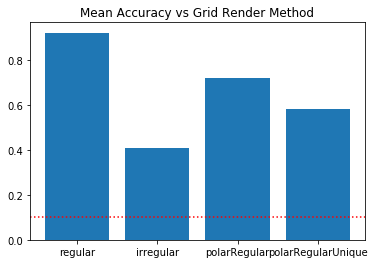

In [52]:
plt.bar(range(ngrids), meanAccuracies, tick_label=gridTypes)
plt.axhline(1 / 10, linestyle=':', color='r')
plt.title("Mean Accuracy vs Grid Render Method")

# What was the mean response time to a cue?

In [43]:
meanResponseTime = [d.cuetime.mean() for d in data]
stdResponseTime = [d.cuetime.std() for d in data]

Text(0.5, 1.0, 'Mean Response Time (ssec) vs Grid Render Method.')

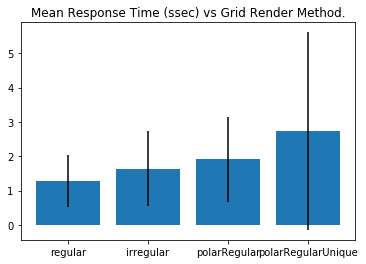

In [54]:
plt.bar(range(ngrids), meanResponseTime, tick_label=gridTypes, yerr=stdResponseTime)
plt.title("Mean Response Time (ssec) vs Grid Render Method.")

# How did performance change over a session?

Text(0.5, 0.98, 'Cumulative performance during a Session')

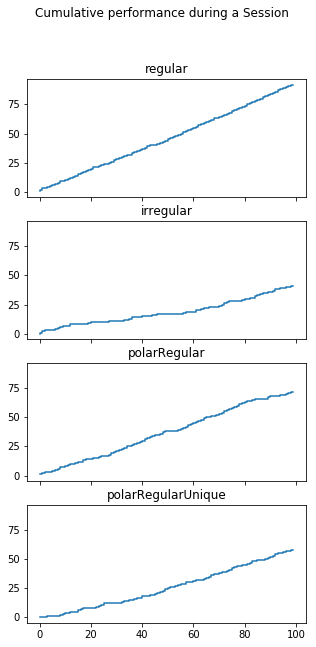

In [87]:
fig, ax = plt.subplots(4, sharex=True, sharey=True, figsize=(5,10))

for i, d in enumerate(data):
    ax[i].step(range(len(d)), np.cumsum((d['digit'] == d['keypress']).astype(int)))
    ax[i].set_title(gridTypes[i])
    
fig.suptitle("Cumulative performance during a Session")

# What numbers were chosen the most?

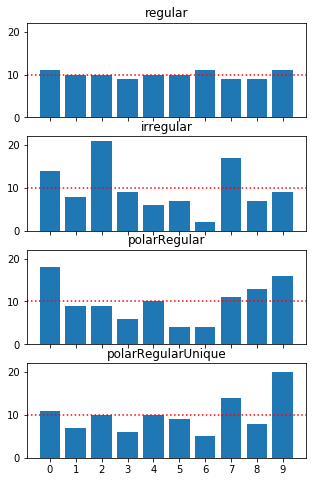

In [214]:
fig, ax = plt.subplots(4, sharex=True, sharey=True, figsize=(5,8))

for i, d in enumerate(data):
    ax[i].bar(range(10), [sum((d.keypress == digit).astype(int)) for digit in range(10)], tick_label=range(10))
    ax[i].axhline(10, color='r', linestyle=':')
    ax[i].set_title(gridTypes[i])

# What numbers were most well recognised?

In [97]:
for d in data:
    d['correct'] = (d.digit == d.keypress).astype(int)

In [123]:
ncues = 10

In [171]:
proportions = [[sum(((d.digit == i) & (d.correct == 1)).astype(int)) / ncues for i in range(10)] for d in data]

Text(0.5, 0.98, 'Accuracy per digit for each Grid')

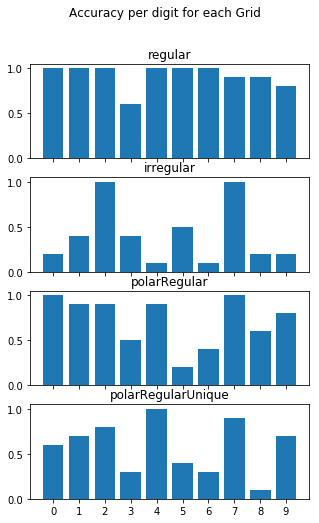

In [181]:
fig, ax = plt.subplots(ngrids, sharex=True, sharey=True, figsize=(5, 8))

for i, props in enumerate(proportions):
    ax[i].bar(range(10), props, tick_label=range(10))
    ax[i].set_title(gridTypes[i])

fig.suptitle('Accuracy per digit for each Grid')

# What numbers were often confused?

In [193]:
from collections import Counter

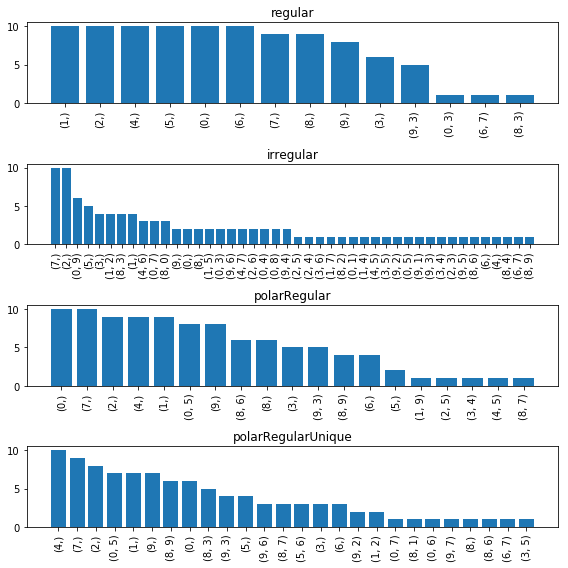

In [222]:
fig, ax = plt.subplots(4, figsize=(8,8))

for i, d in enumerate(data):
    keypairs = []
    for row in d.iterrows():
        keypair = tuple(frozenset((int(row[1].digit), int(row[1].keypress))))
        keypairs.append(keypair)
    c = Counter(keypairs).most_common()
    ax[i].bar(range(len(c)), [el[1] for el in c], tick_label=[str(el[0]) for el in c])
    ax[i].set_title(gridTypes[i])
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
fig.tight_layout()